# Prepare kaggle environment

In order to create a Kaggle environment in Colab, we will need to install the Kaggle library, upload our Kaggle credentials, and download and uncompress the target dataset. Once set up, we will have seamless access to Kaggle datasets and the ability to compete in machine learning competitions./


In [ ]:
# Install kaggle library
!pip install kaggle

In [ ]:
# Upload kaggle credential
from google.colab import files

uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
# Prepare kaggle environment
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

100% 2.04G/2.04G [00:22<00:00, 55.0MB/s]
100% 2.04G/2.04G [00:22<00:00, 97.7MB/s]


In [ ]:
# decompress dataset
!unzip plantvillage-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727_final_mas

# Getting dataset from Exploracion de Datos

In [ ]:
import pandas as pd

!git clone https://github.com/deeplearningcourse23/artifacts
dataset_path = "artifacts/transformed_categories.csv"
dataset_df = pd.read_csv(dataset_path)
dataset_df

Cloning into 'artifacts'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), 1.37 MiB | 2.68 MiB/s, done.


,CATEGORY,IMAGE_PATH,_merge,CATEGORY_BIN
0,Tomato___Bacterial_spot,/content/plantvillage dataset/color/Tomato___B...,left_only,no healthy
1,Tomato___Bacterial_spot,/content/plantvillage dataset/color/Tomato___B...,left_only,no healthy
2,Tomato___Bacterial_spot,/content/plantvillage dataset/color/Tomato___B...,left_only,no healthy
3,Tomato___Bacterial_spot,/content/plantvillage dataset/color/Tomato___B...,left_only,no healthy
4,Tomato___Bacterial_spot,/content/plantvillage dataset/color/Tomato___B...,left_only,no healthy
...,...,...,...,...
53533,Tomato___Spider_mites Two-spotted_spider_mite,/content/plantvillage dataset/color/Tomato___S...,left_only,no healthy
53534,Tomato___Spider_mites Two-spotted_spider_mite,/content/plantvillage dataset/color/Tomato___S...,left_only,no healthy
53535,Tomato___Spider_mites Two-spotted_spider_mite,/content/plantvillage dataset/color/Tomato___S...,left_only,no healthy
53536,Tomato___Spider_mites Two-spotted_spider_mite,/content/plantvillage dataset/color/Tomato___S...,left_only,no healthy


# Generating labels

In [ ]:
from sklearn import preprocessing

# Converting labels from category to numeric
label_encoder = preprocessing.LabelEncoder()
dataset_df["CATEGORY_BIN_ENCODED"] = label_encoder.fit_transform(dataset_df["CATEGORY_BIN"])
dataset_df[["CATEGORY_BIN_ENCODED", "CATEGORY_BIN"]].drop_duplicates()

,CATEGORY_BIN_ENCODED,CATEGORY_BIN
0,1,no healthy
4120,0,healthy


In [ ]:
# Splitting dataframe columns into features
y, x = dataset_df["CATEGORY_BIN_ENCODED"], dataset_df["IMAGE_PATH"]

# Basic denoising

In [ ]:
import cv2
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import itertools
import more_itertools

# Defining 2 types of preprocessing
# 1. basic_preprocessing: this preprocessing just transform the image and apply a median filter to remove noise
# 2. Applies basic_preprocessing and remove mean from the image

def basic_preprocessing(path):
  target_resolution = (256, 256)
  img_bgr = cv2.imread(path)
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  resize_image = cv2.resize(img_rgb, target_resolution)
  denoised_image = cv2.medianBlur(resize_image, 3)
  return denoised_image


def remove_median(path):
    # Retrieve image
    image = basic_preprocessing(path)

    return abs(image - np.median(image))

def scaling(path):
    # Retrieve image
    image = basic_preprocessing(path)
    image_center = image.astype(np.float) - np.median(image)
    max = image_center.max()
    min = image_center.min()
    factor = 1/(max - min)
    processed = factor * image_center
    return processed

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, function, scaling = 255.0):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.function = function
        self.indexes = np.arange(len(self.image_paths))
        self.scaling = scaling

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size

        batch_image_paths = self.image_paths[start:end]
        batch_labels = self.labels[start:end]

        batch_images = [self.function(image_path) for image_path in batch_image_paths]
        batch_images = np.array(batch_images) / self.scaling  # Normalize pixel values

        return batch_images, np.array(batch_labels)

# Result

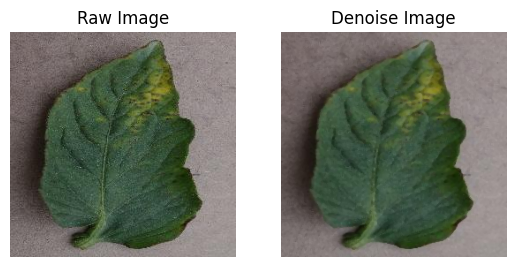

In [ ]:
# Showing example

batch_size = 32
data_generator = CustomDataGenerator(
      x,
      y,
      batch_size,
      basic_preprocessing
    )

sample_index = 16
batch_id = 0
index_data = 0
sample_image = data_generator[batch_id][index_data][sample_index]

fig, axs = plt.subplots(1, 2)
sample_images = [
    (cv2.cvtColor(cv2.imread(dataset_df["IMAGE_PATH"].loc[sample_index]), cv2.COLOR_BGR2RGB), "Raw Image"), # Raw image
    (sample_image, "Denoise Image") # preprocess image
    ]

for i, ax in enumerate(axs.flat):
    image, title = sample_images[i]
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

plt.show()

As we can see, the denoise image contains less noise than the raw image

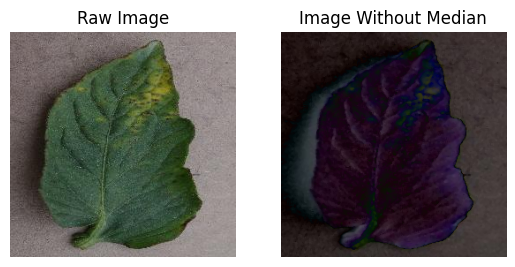

In [ ]:
# Showing example

batch_size = 32
data_generator = CustomDataGenerator(
      x,
      y,
      batch_size,
      remove_median
    )

sample_index = 16
batch_id = 0
index_data = 0
sample_image = data_generator[batch_id][index_data][sample_index]

fig, axs = plt.subplots(1, 2)
sample_images = [
    (cv2.cvtColor(cv2.imread(dataset_df["IMAGE_PATH"].loc[sample_index]), cv2.COLOR_BGR2RGB), "Raw Image"), # Raw image
    (sample_image, "Image Without Median") # preprocess image
    ]

for i, ax in enumerate(axs.flat):
    image, title = sample_images[i]
    ax.imshow(image, cmap="gray")
    ax.set_title(title)
    ax.axis('off')

plt.show()

<ipython-input-44-55467ce2c501>:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image_center = image.astype(np.float) - np.median(image)


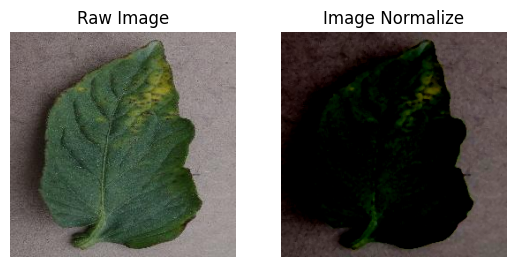

In [54]:
# Showing example

batch_size = 32
data_generator = CustomDataGenerator(
      x,
      y,
      batch_size,
      scaling,
      scaling=1.0
    )

sample_index = 16
batch_id = 0
index_data = 0
sample_image = data_generator[batch_id][index_data][sample_index]

fig, axs = plt.subplots(1, 2)
sample_images = [
    (cv2.cvtColor(cv2.imread(dataset_df["IMAGE_PATH"].loc[sample_index]), cv2.COLOR_BGR2RGB), "Raw Image"), # Raw image
    (sample_image, "Image Normalize") # preprocess image
    ]

for i, ax in enumerate(axs.flat):
    image, title = sample_images[i]
    ax.imshow(image, cmap="gray")
    ax.set_title(title)
    ax.axis('off')

plt.show()